In [1]:
import networkx as nx
import utils as u
from tqdm.notebook import tqdm
from collections import Counter
from itertools import chain
from typing import List, Tuple
import matplotlib.pyplot as plt

mpl_params = {

    'figure.figsize': (25, 13),
}
plt.rcParams.update(mpl_params)

G = u.load_graph()

In [10]:
def calc_greedy_paths2(_orders):
    _paths = [nx.shortest_path(G, x[0], x[1], 'dist') for x in _orders]
    _orders_paths = dict(zip(_orders, _paths))
    _used_edges = list(chain(*[u.edges_from_path(x) for x in _paths]))

    _used_edges_payload = Counter(_used_edges)

    _paths_final = []
    _used_edges_final = []
    j = 1
    i = 0
    paths_tmp = _paths[:]
    for order, _path in tqdm(_orders_paths.items()):
        for edge in u.edges_from_path(_path):
            _used_edges_payload[edge] -= 1
        order_price_on_edges = {}
        for edge, payload in _used_edges_payload.items():
            edge_attributes = G[edge[0]][edge[1]]
            predicted_price = u.calc_price(edge_attributes['type'], edge_attributes['dist'], payload + 1)
            actual_price = u.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
            order_price_on_edge = predicted_price - actual_price
            order_price_on_edges[edge] = round(order_price_on_edge, 1)


        plt.figure(j)
        u.draw_graph(G, ['nodes'])
        for k, p in enumerate(paths_tmp):
            if k != i:
                nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, 'pos'), edgelist=u.edges_from_path(p),
                           alpha=0.6,
                           arrows=True, arrowstyle='->', width=4.5,
                           edge_color='blue')

        plt.figure(j + 1)
        u.draw_graph(G, ['nodes'])
        #nx.draw_networkx_edge_labels(G, nx.get_node_attributes(G, 'pos'), edge_labels=order_price_on_edges)

        nx.set_edge_attributes(G, order_price_on_edges, 'greedy_price2')
        _path = nx.shortest_path(G, order[0], order[1], 'greedy_price2')

        nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, 'pos'), edgelist=u.edges_from_path(_path),
                           alpha=1,
                           arrows=True, arrowstyle='->', width=4.5,
                           edge_color='red')

        _paths_final.append(_path)
        paths_tmp[i] = _path
        _path_edges = u.edges_from_path(_path)
        for edge in _path_edges:
            _used_edges_payload[edge] += 1
            _used_edges_final.append(edge)
        j  += 2
        i += 1
    used_edges_payload_final = Counter(_used_edges_final)

    return _orders, _paths_final, used_edges_payload_final

  0%|          | 0/3 [00:00<?, ?it/s]

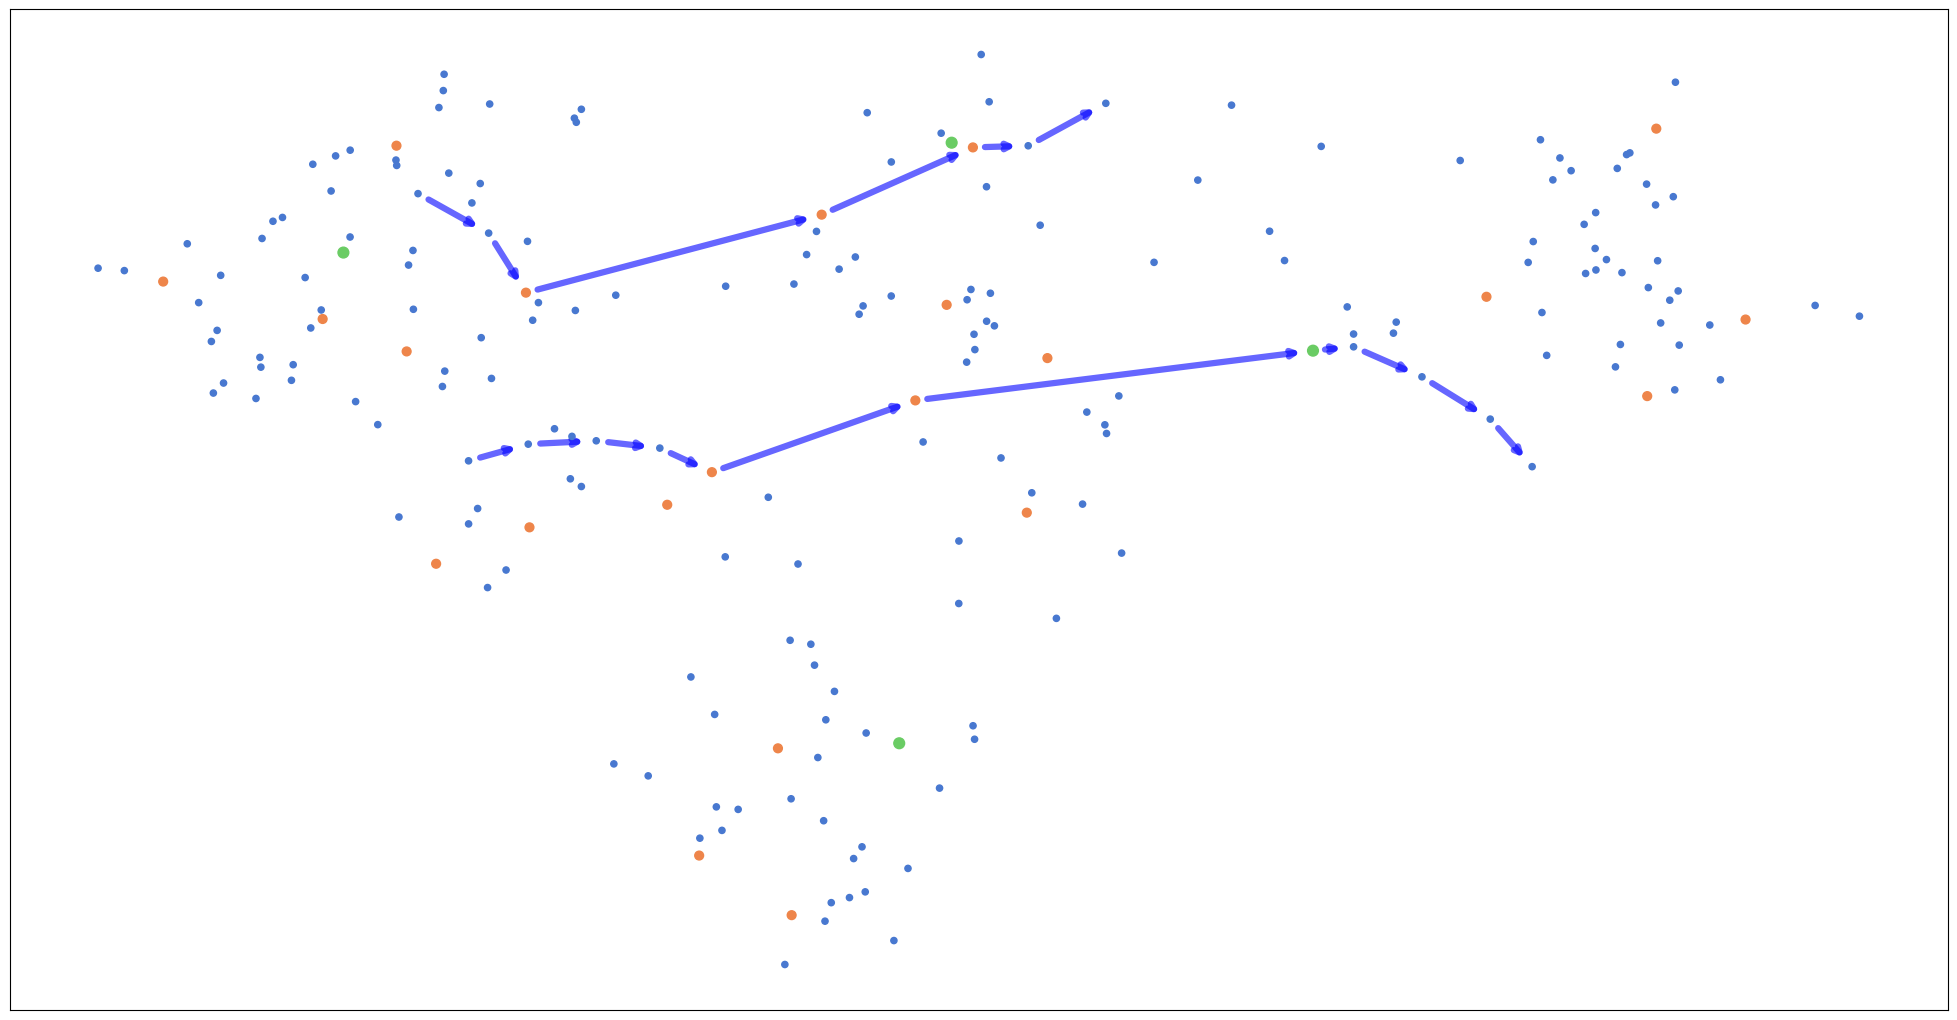

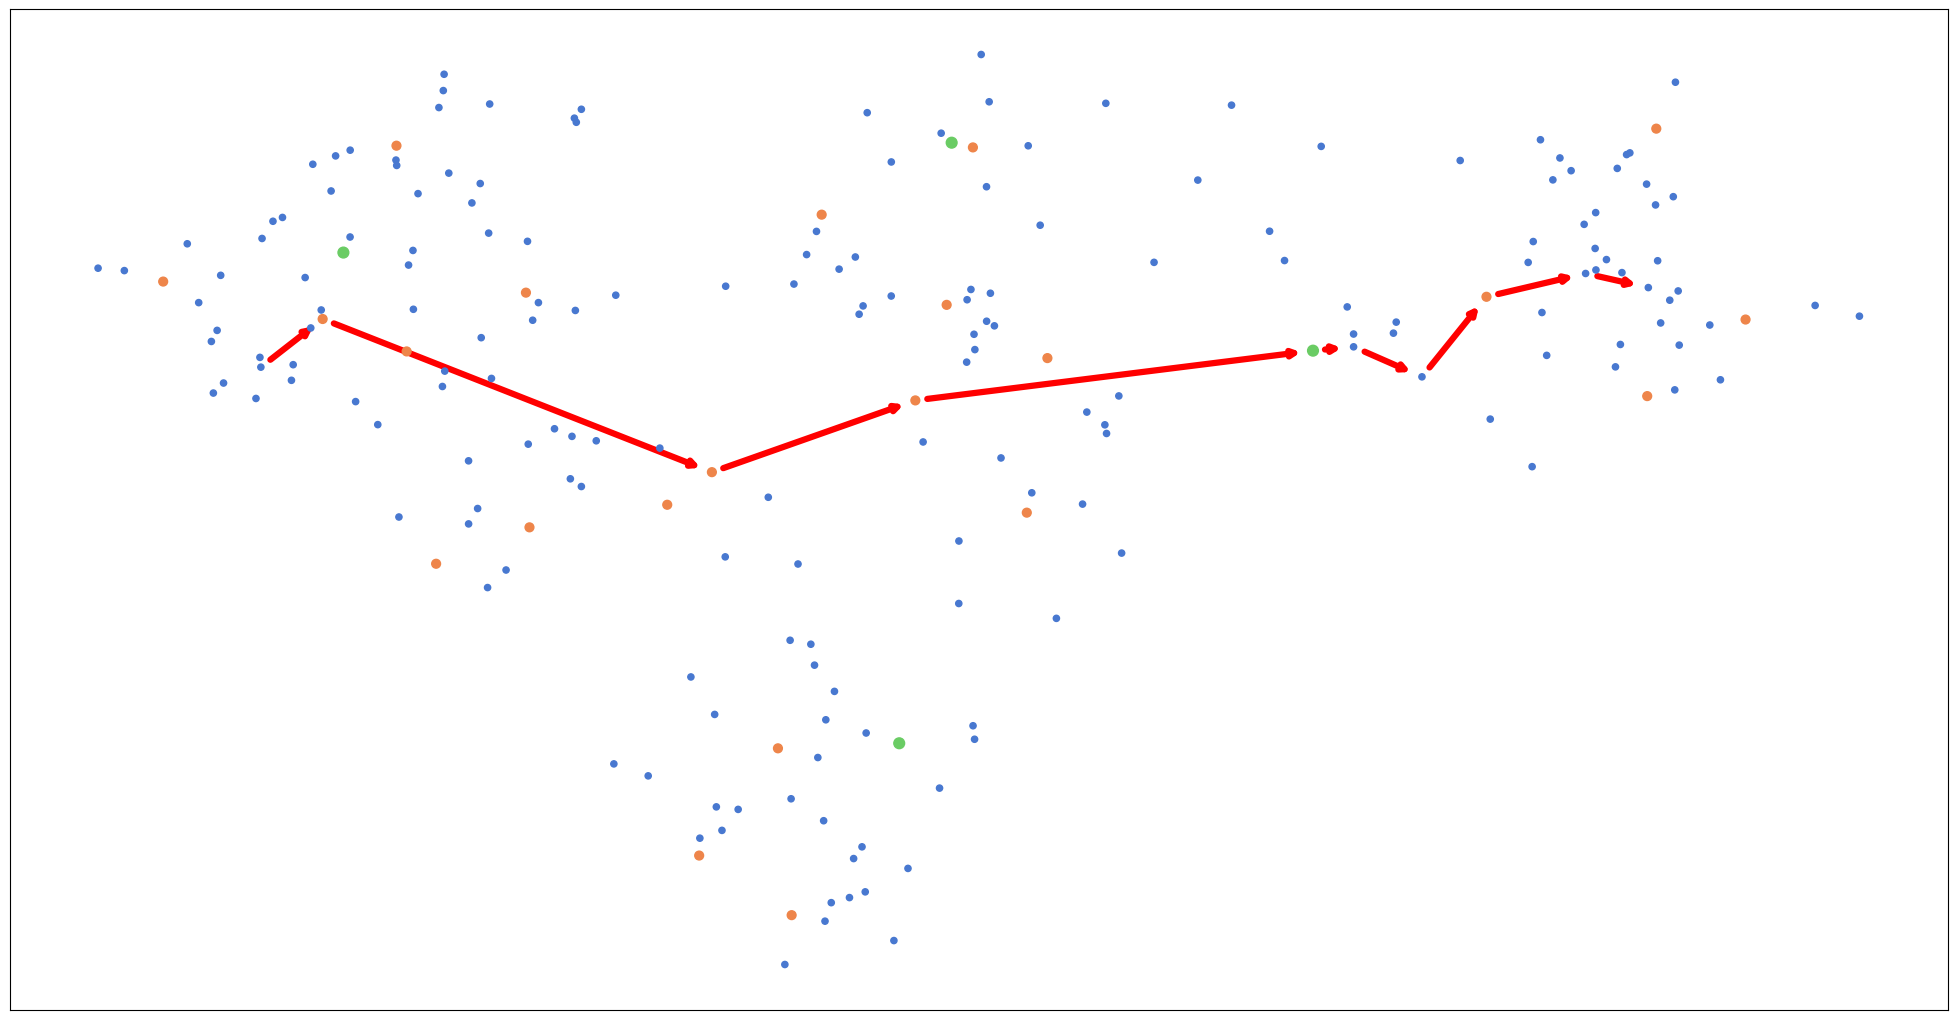

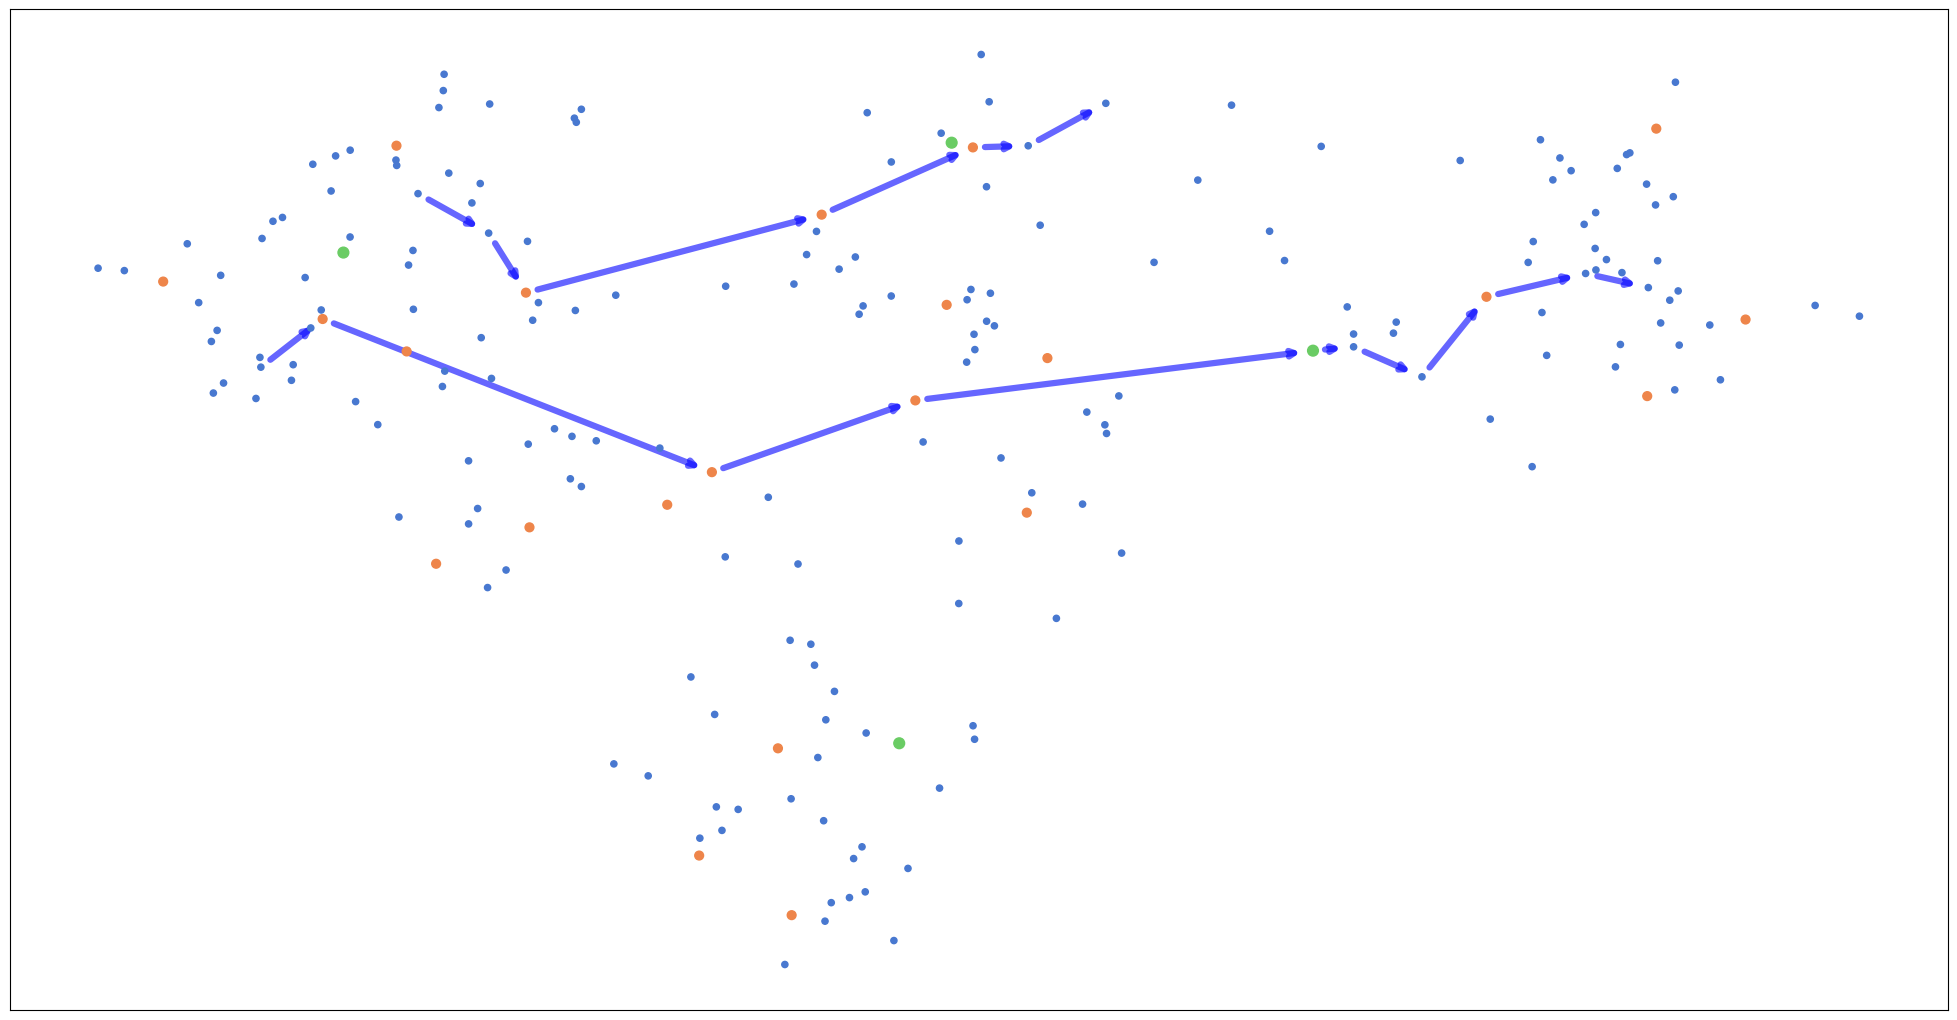

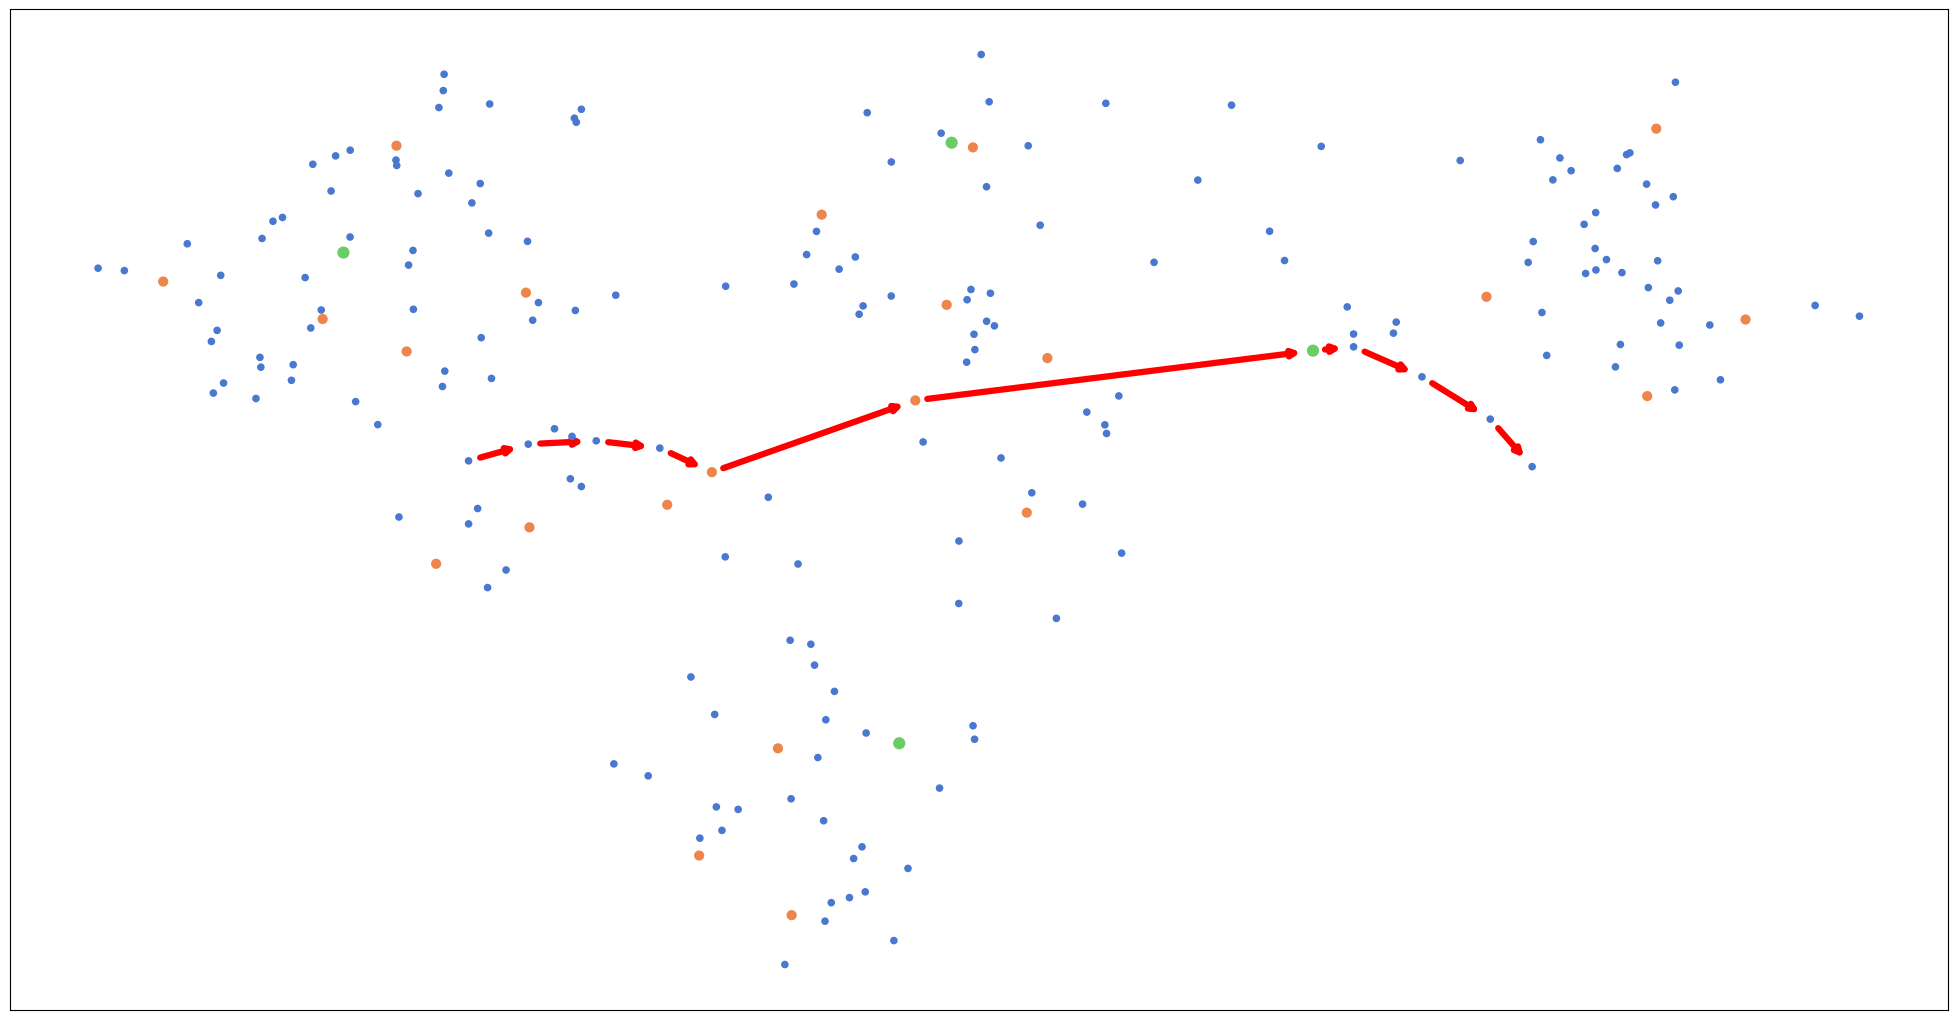

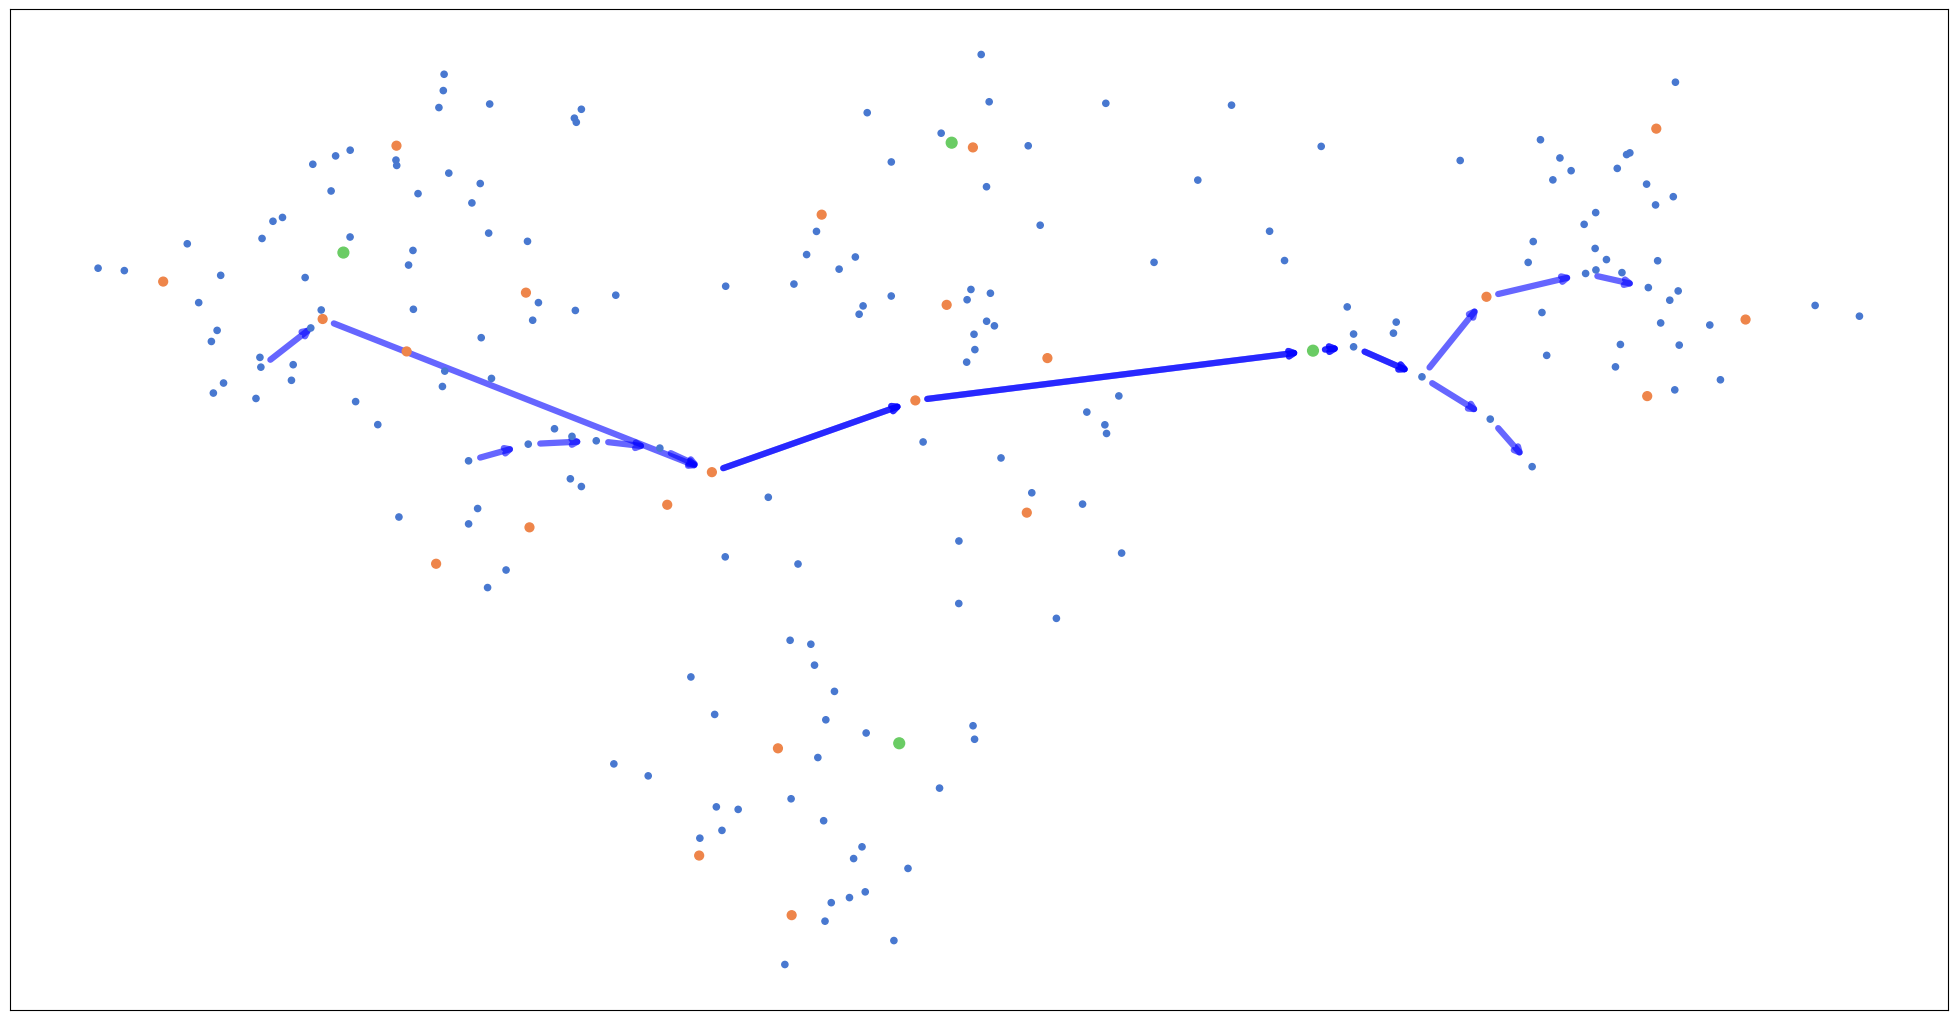

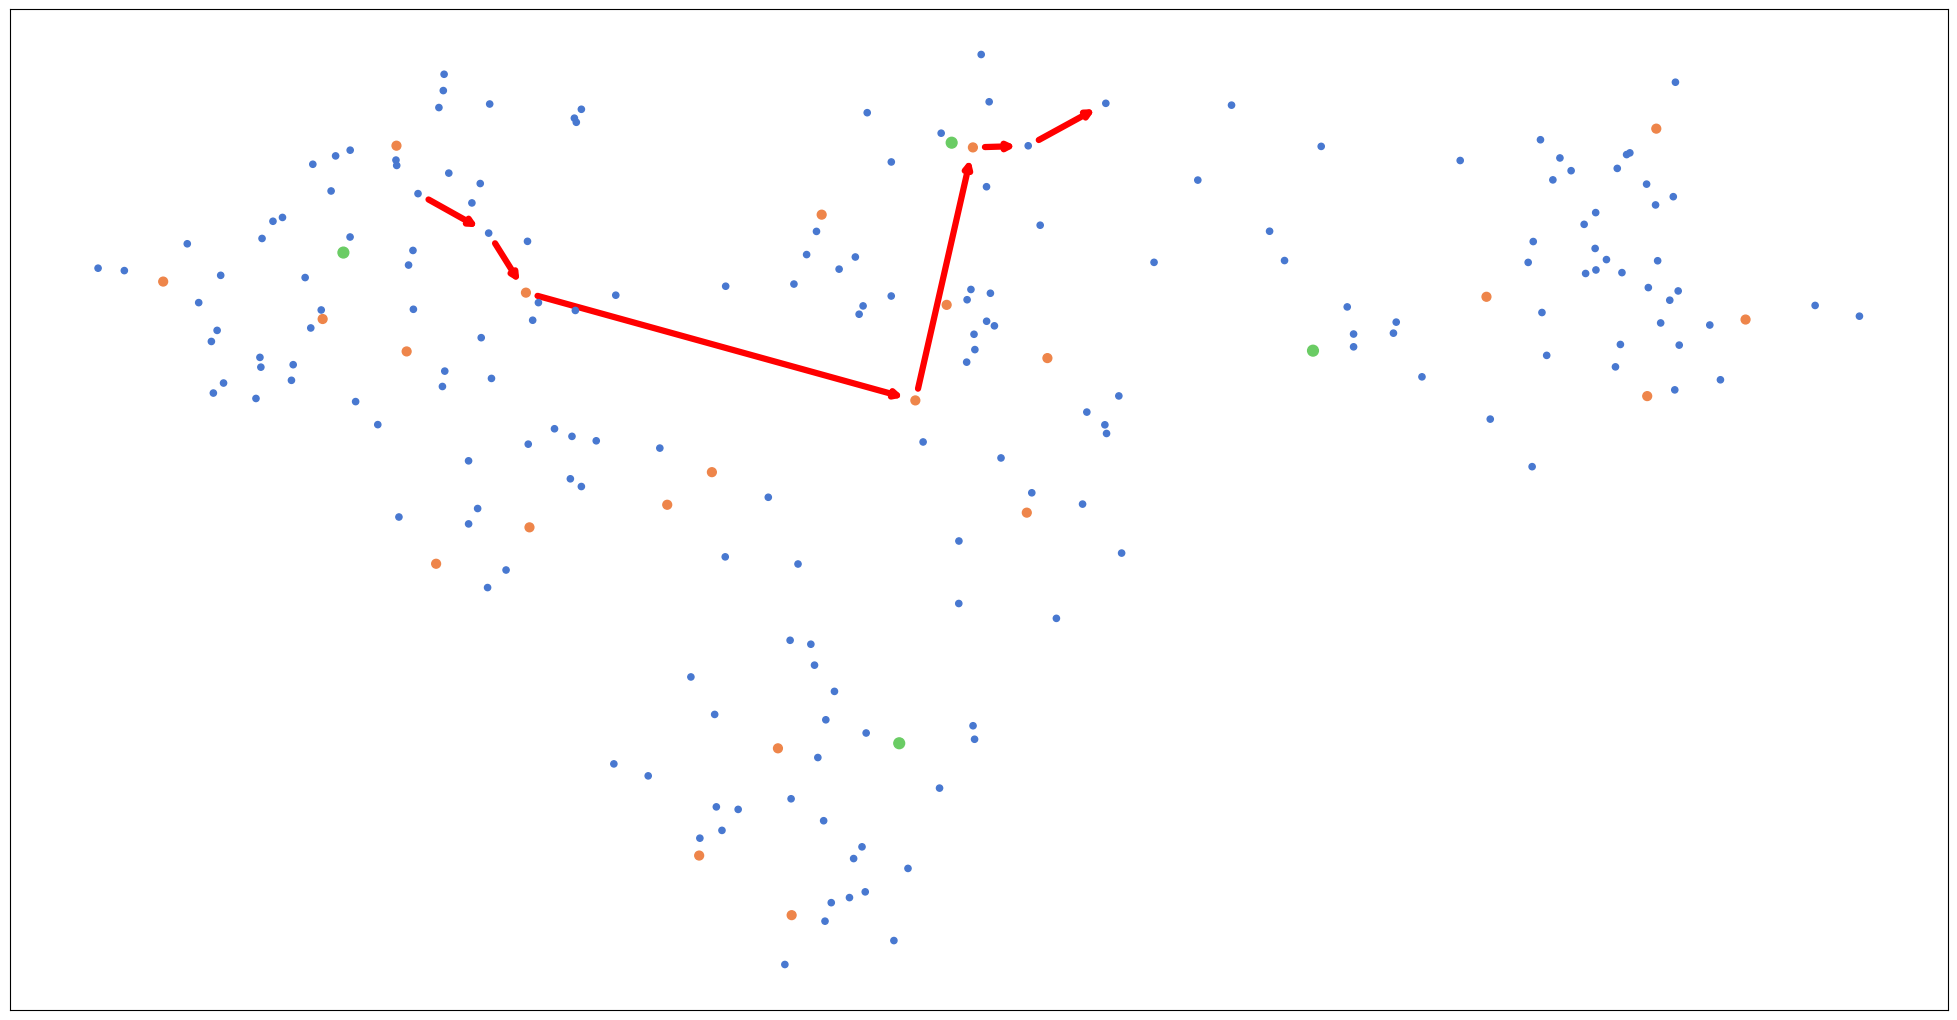

In [11]:
_, paths, edges_payload = calc_greedy_paths2([(30, 141), (171, 172), (107, 206)])

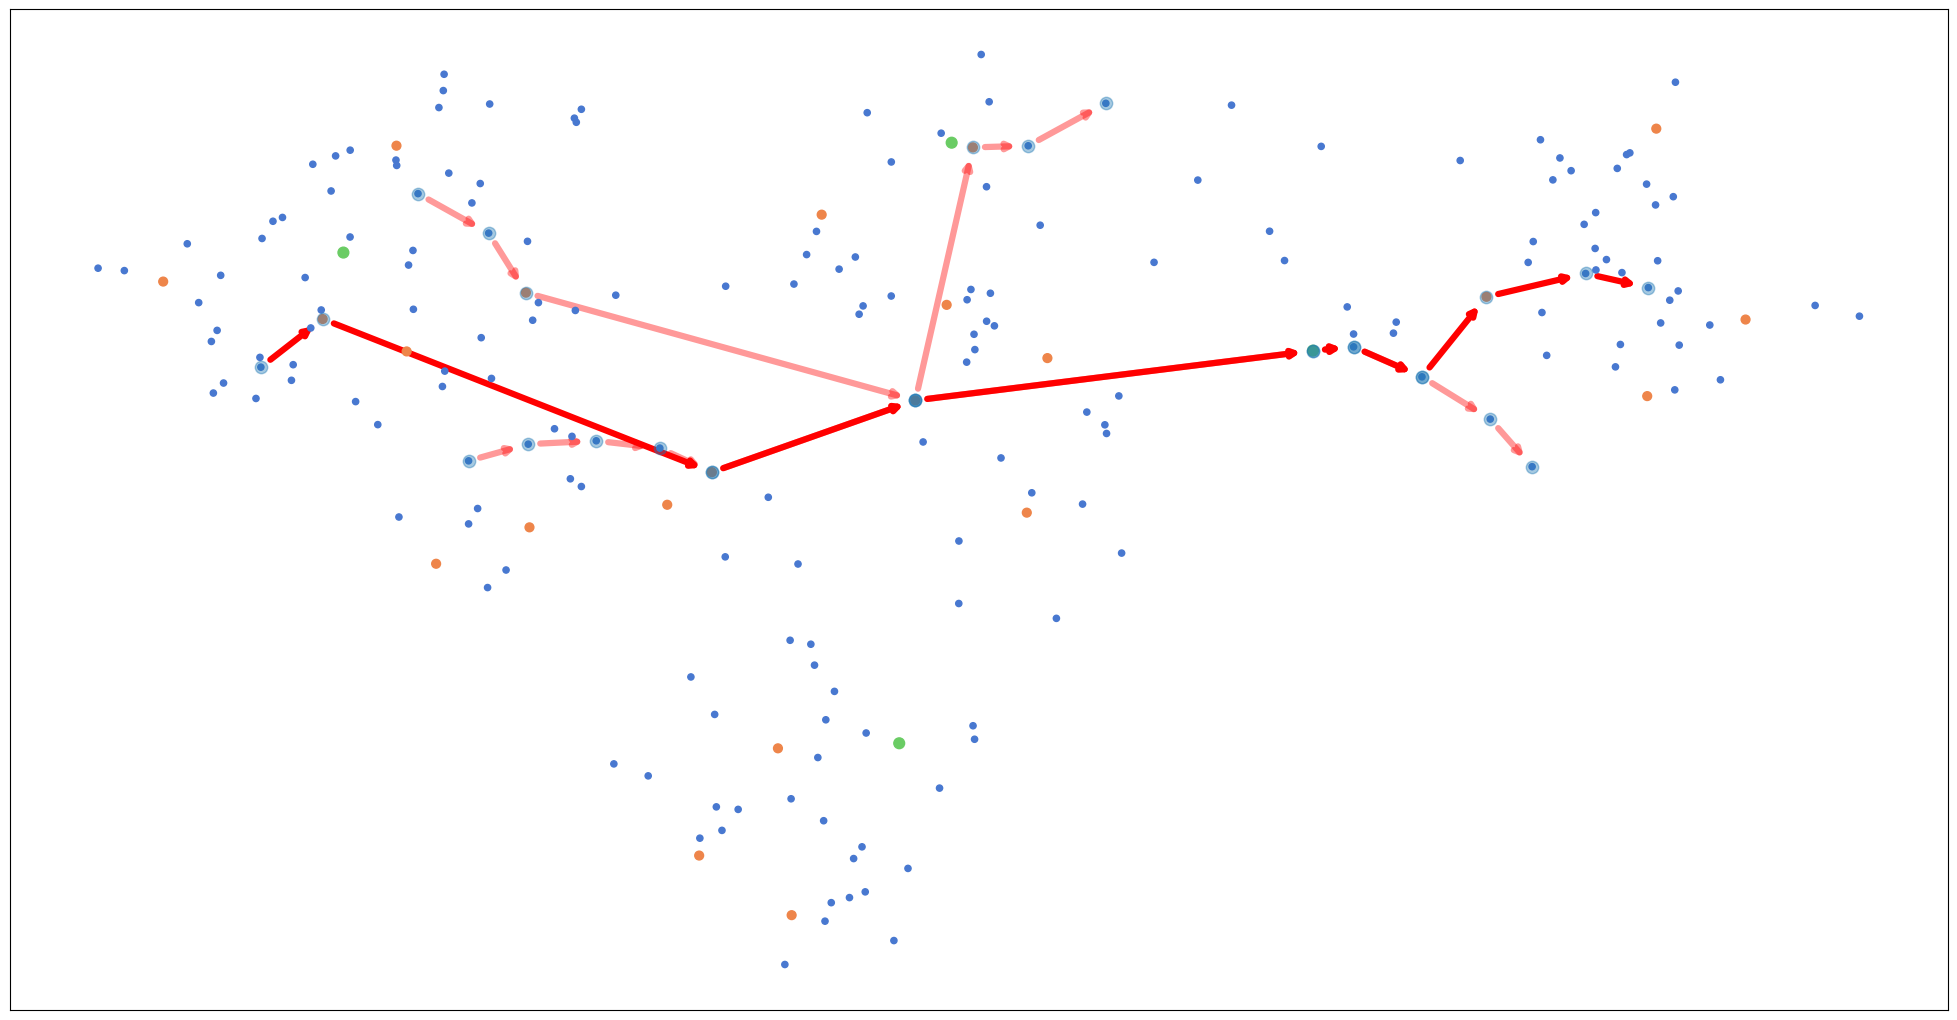

In [12]:
u.draw_graph(G, ['nodes'])
for index, path in enumerate(paths):
    nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, 'pos'), edgelist=u.edges_from_path(path),
                           alpha=1 if index == 0 else 0.4,
                           arrows=True, arrowstyle='->', width=4.5,
                           edge_color='red')
    nx.draw_networkx_nodes(G, pos=nx.get_node_attributes(G, 'pos'), nodelist=path, alpha=0.4, node_size=80)

  0%|          | 0/8936 [00:00<?, ?it/s]

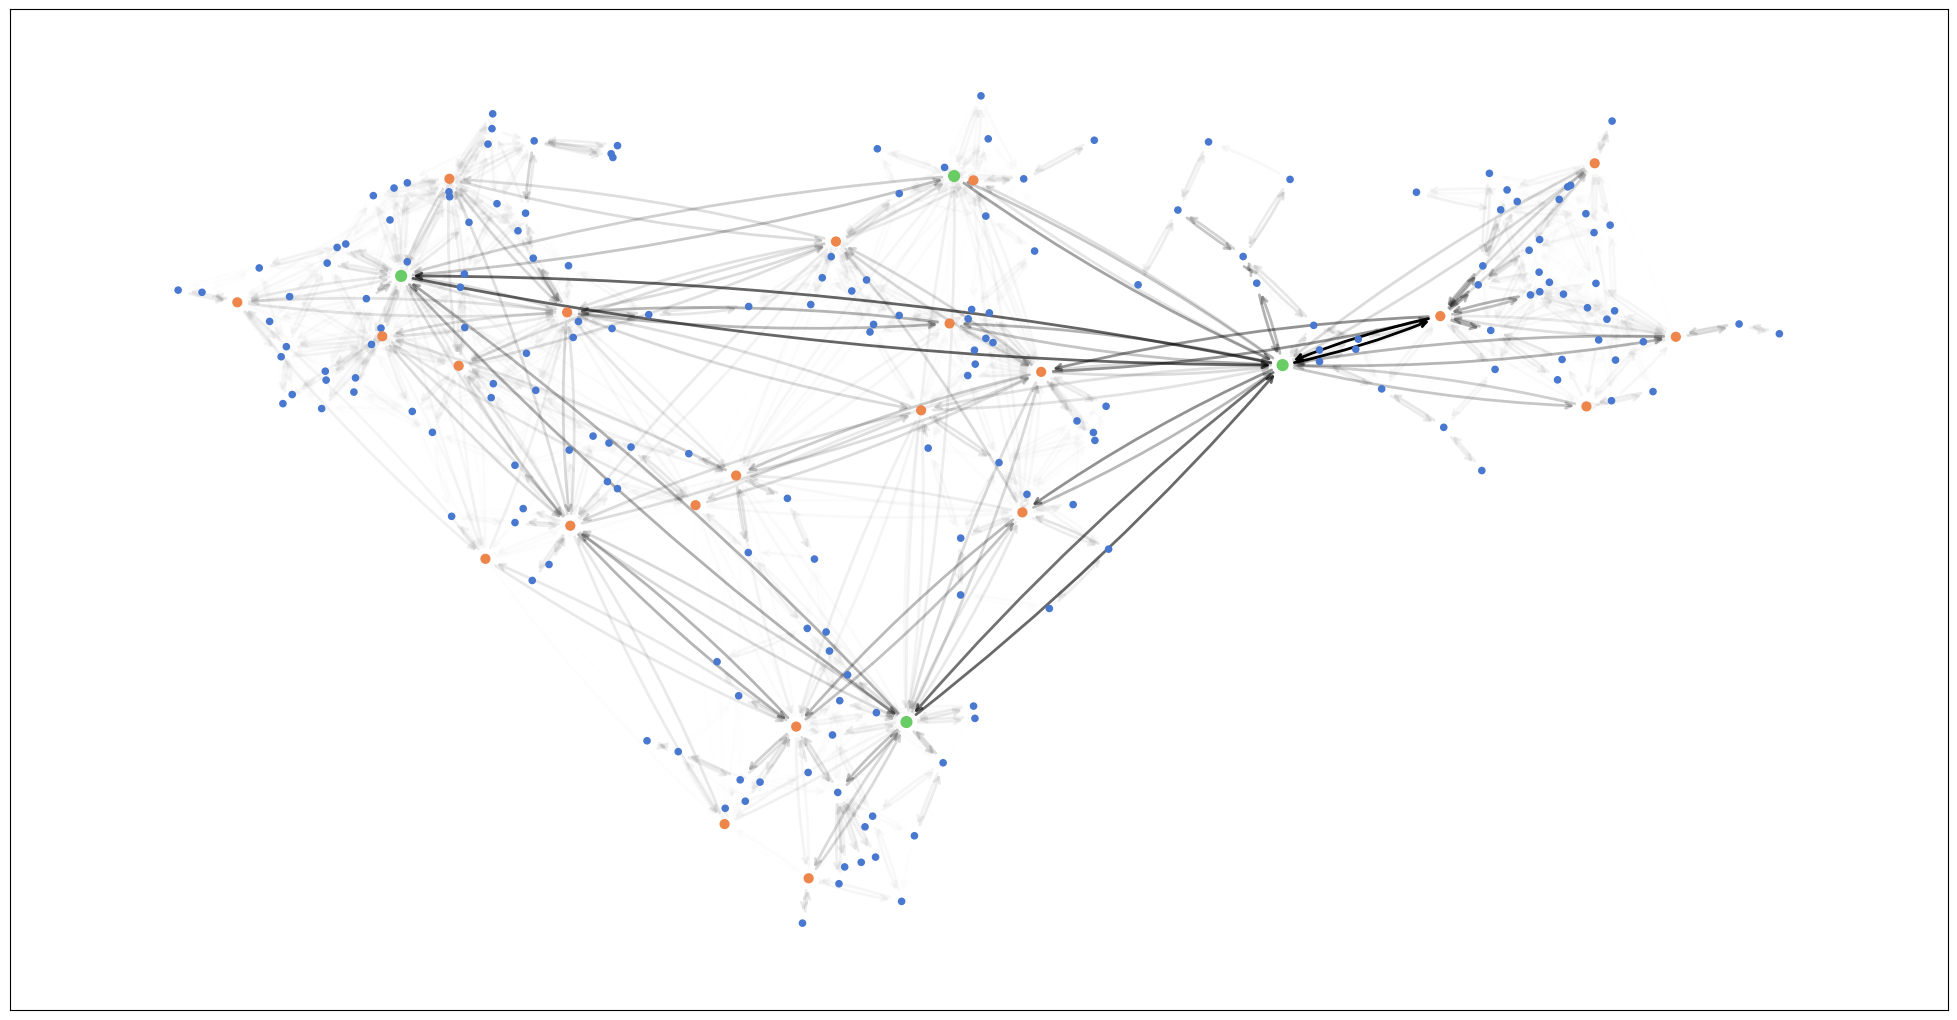

In [12]:
_, _, edges_payload = calc_greedy_paths2(u.generate_orders(G, 10000))
u.draw_payload(G, edges_payload)

In [13]:
edges_prices, total_price =  u.calc_total_price(G, edges_payload)
total_price

2651.4332331736837

In [14]:
orders_groups = []
for count in tqdm(range(5000, 100001, 5000)):
    orders_groups.append(u.generate_orders(G, count))
list(map(len, orders_groups))

  0%|          | 0/20 [00:00<?, ?it/s]

[5000,
 10000,
 15000,
 20000,
 25000,
 30000,
 35000,
 40000,
 45000,
 50000,
 55000,
 60000,
 65000,
 70000,
 75000,
 80000,
 85000,
 90000,
 95000,
 100000]

In [15]:
import time

results = []
for orders in tqdm(orders_groups):
    t0 = time.time()
    _, paths, edges_payload = calc_greedy_paths2(orders)
    edges_prices, total_price =  u.calc_total_price(G, edges_payload)
    results.append(u.Result(orders, paths, edges_payload, edges_prices, total_price, time.time() - t0))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4754 [00:00<?, ?it/s]

  0%|          | 0/8963 [00:00<?, ?it/s]

  0%|          | 0/12724 [00:00<?, ?it/s]

  0%|          | 0/16140 [00:00<?, ?it/s]

  0%|          | 0/19181 [00:00<?, ?it/s]

  0%|          | 0/21858 [00:00<?, ?it/s]

  0%|          | 0/24323 [00:00<?, ?it/s]

  0%|          | 0/26476 [00:00<?, ?it/s]

  0%|          | 0/28361 [00:00<?, ?it/s]

  0%|          | 0/30147 [00:00<?, ?it/s]

  0%|          | 0/31635 [00:00<?, ?it/s]

  0%|          | 0/33095 [00:00<?, ?it/s]

  0%|          | 0/34266 [00:00<?, ?it/s]

  0%|          | 0/35387 [00:00<?, ?it/s]

  0%|          | 0/36339 [00:00<?, ?it/s]

  0%|          | 0/37247 [00:00<?, ?it/s]

  0%|          | 0/38037 [00:00<?, ?it/s]

  0%|          | 0/38666 [00:00<?, ?it/s]

  0%|          | 0/39434 [00:00<?, ?it/s]

  0%|          | 0/39932 [00:00<?, ?it/s]

In [16]:
import pickle

f = open('results/greedy2.pkl', 'wb')
pickle.dump(results, f)
f.close()

In [17]:
f = open('results/greedy2.pkl', 'rb')
results = pickle.load(f)
f.close()

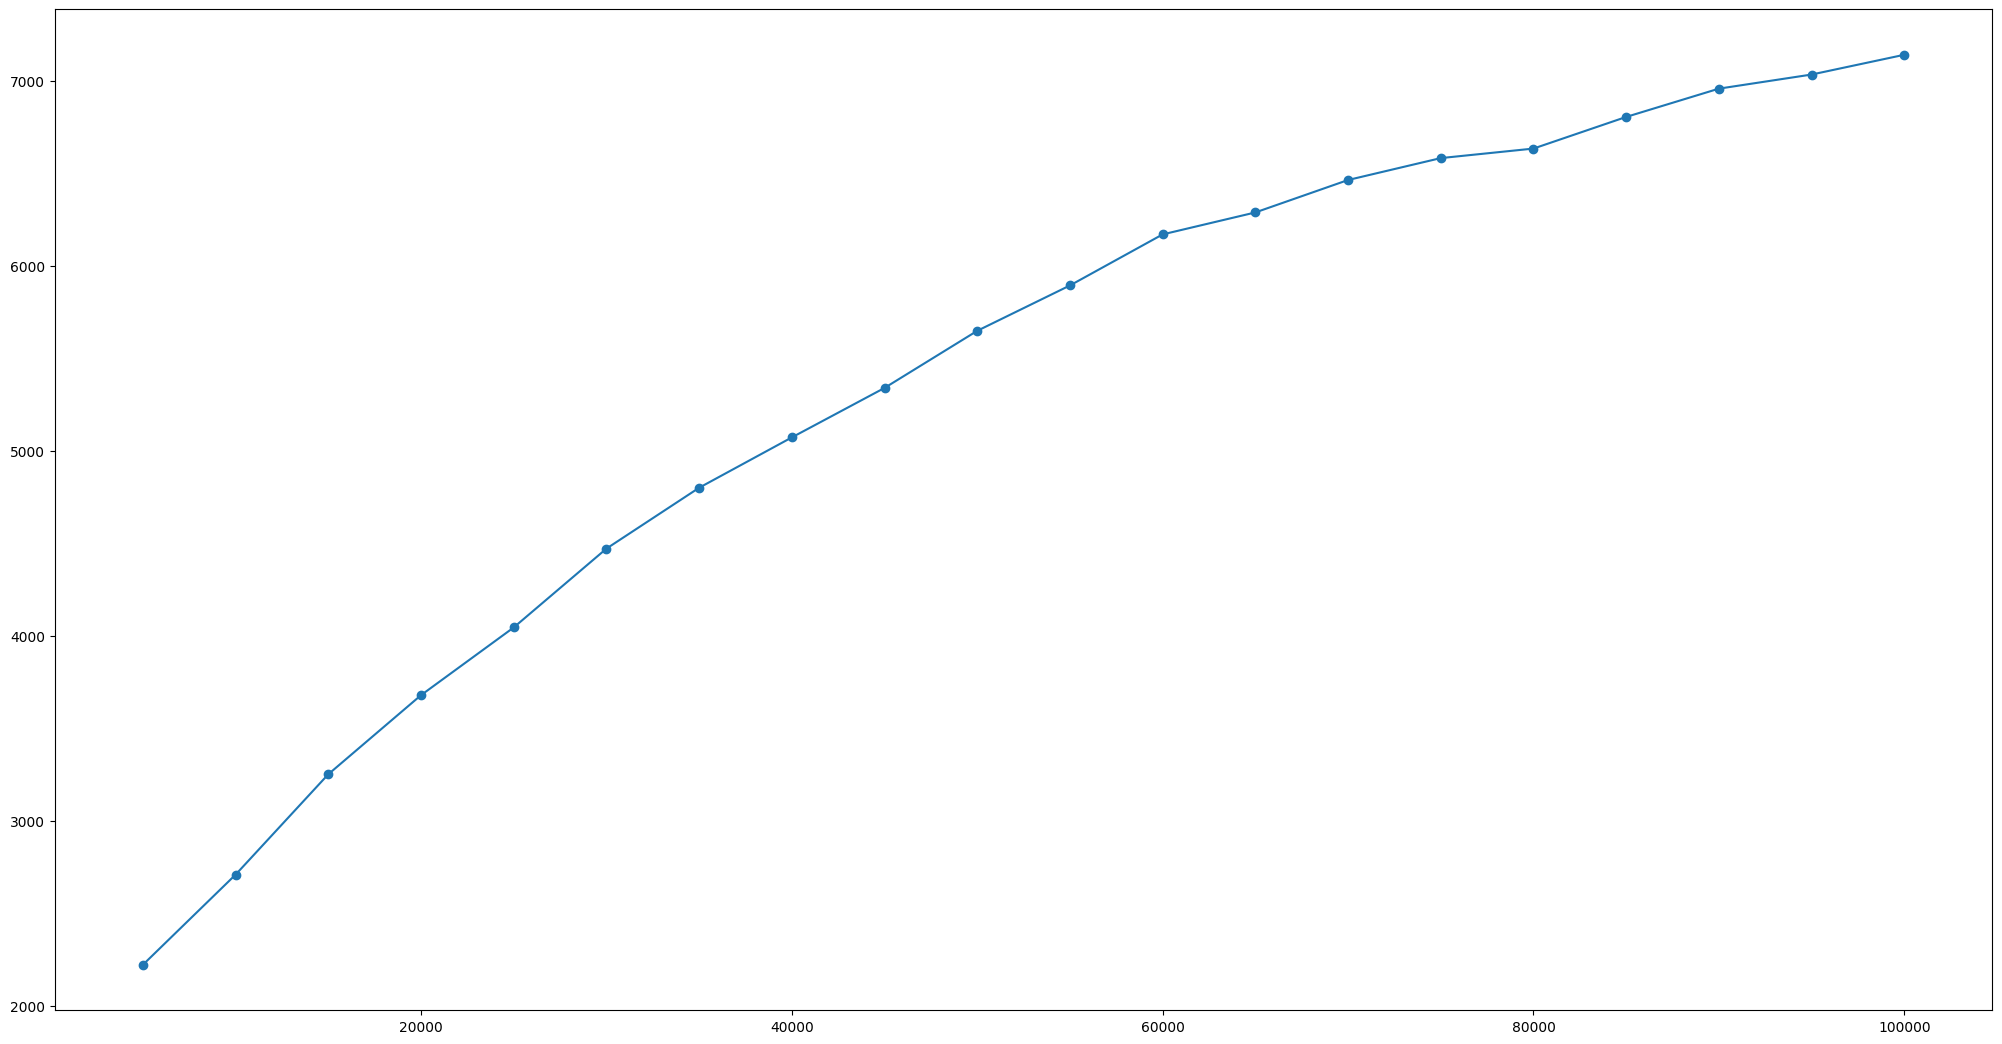

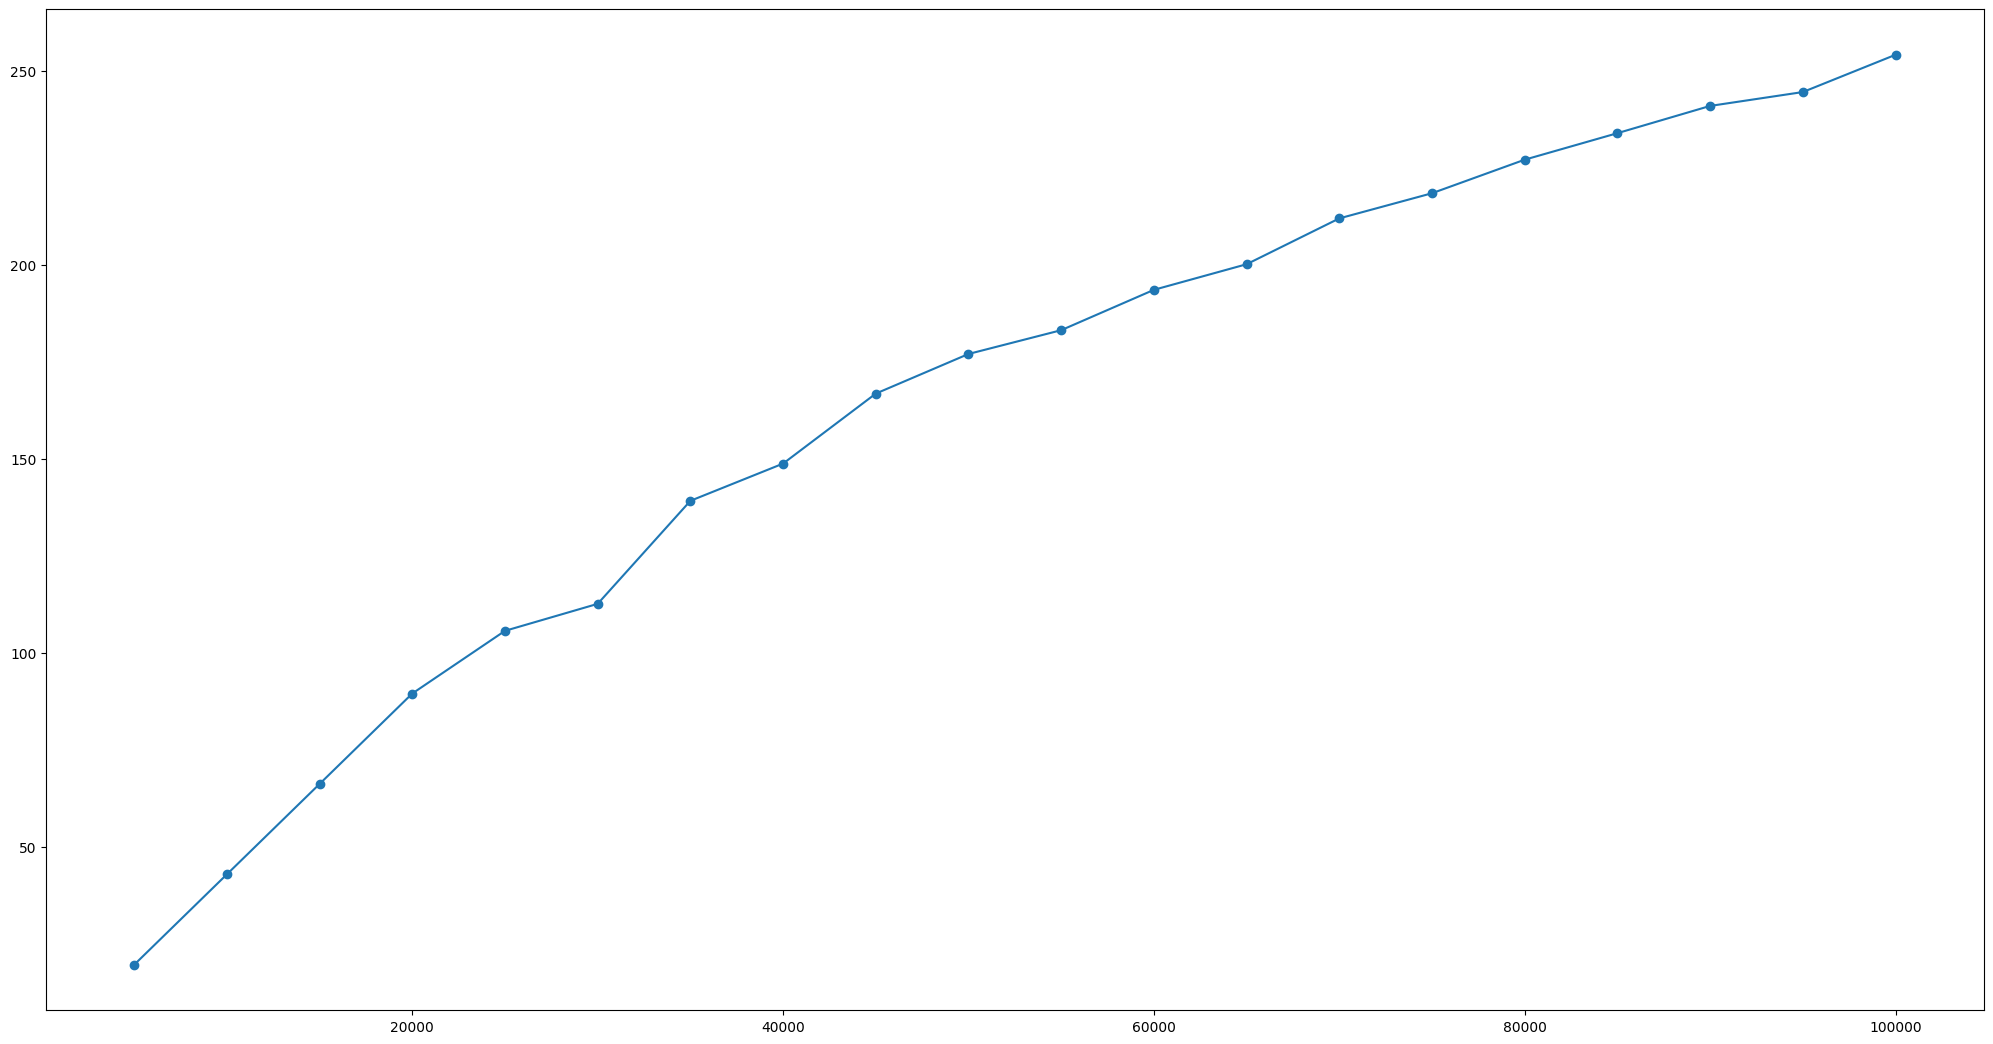

In [18]:
prices = []
times = []
orders_count = []

for result in results:
    prices.append(result.total_price)
    times.append(result.time)
    orders_count.append(len(result.orders))

plt.figure(1)
plt.plot(orders_count, prices)
plt.scatter(orders_count, prices)
plt.figure(2)
plt.plot(orders_count, times)
plt.scatter(orders_count, times)